In [1]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
import seaborn as sns
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.power import tt_ind_solve_power
from tqdm import tqdm

/Users/o.weisse/switchback_test_dag/venv/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [2]:
client = bigquery.Client(project = 'logistics-data-staging-flat')

In [3]:
test_name = 'CL_20230428_R_B0_O_AntofagastaClusteringStrategy'
test_name = "TH_20220721_R_F0_O_Switchback_AA_Test_Trang"
start_date = "2022-07-20"
end_date = "2022-08-18"

In [4]:
query = f"""
SELECT 
        -- Identifiers and supplementary fields     
        -- Date and time
        a.created_date AS created_date_utc,
        a.order_placed_at,

        -- Location of order
        a.region,
        a.entity_id,
        a.country_code,
        a.city_name,
        a.city_id,
        a.zone_name,
        a.zone_id,

        -- Order/customer identifiers and session data
        a.variant,
        a.experiment_id AS test_id,
        b.test_name,
        a.platform_order_code,
        a.order_id,
        a.scheme_id,
        a.vendor_price_scheme_type,	-- The assignment type of the scheme to the vendor during the time of the order, such as "Automatic", "Manual", "Campaign", and "Country Fallback".
        
        --KPIs that we want to measure
        orders.rider.timings.actual_delivery_time/60 delivery_time,
        orders.rider.timings.order_delay/60 order_delay,
        --orders.rider.deliveries.dropoff_distance_dte distance
        
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2` a
    LEFT JOIN `fulfillment-dwh-production.cl.dps_ab_test_orders_v2` b ON a.entity_id = b.entity_id AND a.order_id = b.order_id
    LEFT JOIN `fulfillment-dwh-production.cl.orders_v2` orders ON a.entity_id = orders.entity_id AND a.platform_order_code = orders.global_order_id
    WHERE TRUE
        AND a.created_date BETWEEN DATE("{start_date}") AND DATE("{end_date}")
        AND b.test_name = "{test_name}" -- Search for relevant tests
        AND a.is_sent -- Successful orders
        AND a.is_own_delivery -- OD orders only
        AND a.variant != "Original" -- Exclude orders from ASAs
        AND a.is_match_experiment_vertical -- Filter for sessions where the parent vertical of the vendor matches the
"""

In [ ]:
bq_storage_client = bigquery_storage.BigQueryReadClient() # Instantiate a BQ storage client

data = client.query(query).result()\
    .to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook')

In [ ]:
#questions

# how many percent of the orders get the "surge treatment"?
# how many percent of the orders are actually affected by surge
# consider minumum window size "surge cycle"
# have you filtered outliers?

In [ ]:
data = data[data['delivery_time']<120]

In [ ]:
sns.kdeplot(data['delivery_time'])

In [ ]:
def randomize_time_unit_assignment(data):
    time_unit_group_dict = {i: np.random.choice(['A', 'B']) for i in data.time_unit.unique()}
    data['group'] = data['time_unit'].map(time_unit_group_dict)

# DT distribution per time unit and per order

In [19]:
data['time_unit'] = data['order_placed_at'].dt.floor('H')

In [22]:
randomize_time_unit_assignment(data)

<AxesSubplot:xlabel='delivery_time', ylabel='Density'>

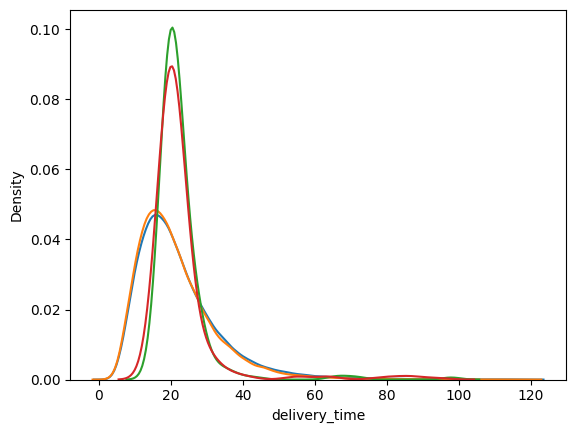

In [24]:
sns.kdeplot(data[data['group']=='A']['delivery_time'])
sns.kdeplot(data[data['group']=='B']['delivery_time'])
sns.kdeplot(data[data['group']=='A'].groupby('time_unit')['delivery_time'].mean())
sns.kdeplot(data[data['group']=='B'].groupby('time_unit')['delivery_time'].mean())

In [25]:
# Generate data points for x-axis
x = np.linspace(20, 25, 100)

In [26]:
mean = data[data['group']=='A']['delivery_time'].mean()
std = data[data['group']=='A']['delivery_time'].std()
N = len(data[data['group']=='A']['delivery_time'])
stderr= std/np.sqrt(N)
DT_mean_A_distr = norm.pdf(x, mean, stderr)

In [27]:
mean = data[data['group']=='B']['delivery_time'].mean()
std = data[data['group']=='B']['delivery_time'].std()
N = len(data[data['group']=='B']['delivery_time'])
stderr= std/np.sqrt(N)
DT_mean_B_distr = norm.pdf(x, mean, stderr)

In [28]:
mean = data[data['group']=='A'].groupby('time_unit')['delivery_time'].mean().mean()
std = data[data['group']=='A'].groupby('time_unit')['delivery_time'].mean().std()
N = len(data[data['group']=='A'].groupby('time_unit')['delivery_time'].mean())
stderr= std/np.sqrt(N)
DT_mean_time_unit_A_distr = norm.pdf(x, mean, stderr)

In [29]:
mean = data[data['group']=='B'].groupby('time_unit')['delivery_time'].mean().mean()
std = data[data['group']=='B'].groupby('time_unit')['delivery_time'].mean().std()
N = len(data[data['group']=='B'].groupby('time_unit')['delivery_time'].mean())
stderr= std/np.sqrt(N)
DT_mean_time_unit_B_distr = norm.pdf(x, mean, stderr)

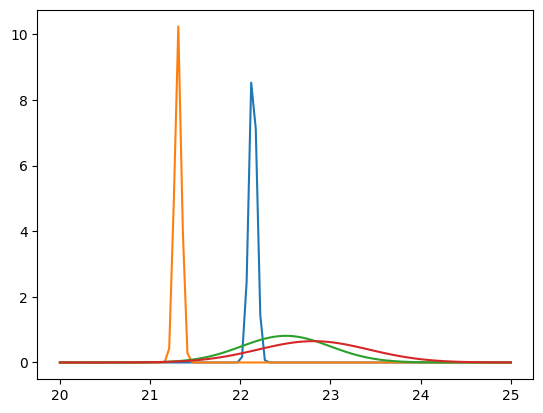

In [30]:
plt.plot(x, DT_mean_A_distr)
plt.plot(x, DT_mean_B_distr)
plt.plot(x, DT_mean_time_unit_A_distr)
plt.plot(x, DT_mean_time_unit_B_distr)

# Naive order level analysis

In [ ]:
def naive_order_level_significane(data, KPI_A, KPI_B, threshold=0):
    _, p, _ = ttest_ind(data[data['group']=='A'][KPI_A], data[data['group']=='B'][KPI_B])
    if p < 0.05:
        return True

In [ ]:
def FPR(data, KPI, check_significance, n_iterations=1000, threshold = 0):
    effect_found = 0
    for i in tqdm(range(n_iterations)):
        randomize_time_unit_assignment(data)
        if check_significance(data, KPI, KPI, threshold):
            effect_found += 1
    return effect_found/n_iterations

In [ ]:
FPR(data, 'delivery_time', naive_order_level_significane, 100)

# Time unit analysis

In [ ]:
def time_unit_significance(data, KPI_A, KPI_B, threshold=0):
    A = data[data['group']=='A'].groupby('time_unit')[KPI_A].mean()
    B = data[data['group']=='B'].groupby('time_unit')[KPI_B].mean()
    _, p, _ = ttest_ind(A, B)
    if p < 0.05:
        return True

In [ ]:
FPR(data, 'delivery_time', time_unit_significance, 100)

In [ ]:
def power(data, KPI, effect_size, check_significance, n_iterations, threshold=0):
    effect_found = 0
    for i in tqdm(range(n_iterations)):
        randomize_time_unit_assignment(data)
        data[KPI+"_simulated"] = data[KPI]+effect_size
        if check_significance(data, KPI, KPI+"_simulated", threshold):
            effect_found += 1
    return effect_found/n_iterations

In [ ]:
power(data, "delivery_time", 1, time_unit_significance, 100)

In [ ]:
N = len(data[data['group']=='A'].groupby('time_unit')['delivery_time'].mean())
std = data[data['group']=='A'].groupby('time_unit')['delivery_time'].mean().std()

In [ ]:
effect_size = 1
std_effect_size = effect_size/std

In [ ]:
tt_ind_solve_power(std_effect_size, nobs1=N, alpha=0.05)

### Power per window size

In [253]:
data['time_unit'] = data['order_placed_at'].dt.floor('H')

N = len(data[data['group']=='A'].groupby('time_unit')['delivery_time'].mean())
std = data[data['group']=='A'].groupby('time_unit')['delivery_time'].mean().std()

effect_size = 1
std_effect_size = effect_size/std

In [254]:
N

249

In [255]:
std

7.669332668832332

In [256]:
tt_ind_solve_power(std_effect_size, nobs1=N, alpha=0.05)

0.3060838714281875

In [257]:
data['time_unit'] = data['order_placed_at'].dt.floor('D')

N = len(data[data['group']=='A'].groupby('time_unit')['delivery_time'].mean())
std = data[data['group']=='A'].groupby('time_unit')['delivery_time'].mean().std()

effect_size = 1
std_effect_size = effect_size/std

In [258]:
N

30

In [259]:
std

2.9385251884377515

In [260]:
tt_ind_solve_power(std_effect_size, nobs1=N, alpha=0.05)

0.2539939401135038

In [261]:
data['time_unit'] = data['order_placed_at'].dt.floor('4H')

N = len(data[data['group']=='A'].groupby('time_unit')['delivery_time'].mean())
std = data[data['group']=='A'].groupby('time_unit')['delivery_time'].mean().std()

effect_size = 1
std_effect_size = effect_size/std

In [262]:
N

134

In [263]:
std

9.1287088952759

In [264]:
tt_ind_solve_power(std_effect_size, nobs1=N, alpha=0.05)

0.1452530675967819

In [265]:
data['time_unit'] = data['order_placed_at'].dt.floor('H')

### Confidence Interval

In [314]:
data['time_unit'] = data['order_placed_at'].dt.floor('H')

N = len(data[data['group']=='A'].groupby('time_unit')['delivery_time'].mean())
std = data[data['group']=='A'].groupby('time_unit')['delivery_time'].mean().std()

In [315]:
std/np.sqrt(N)

0.6118708737046971

# Adjusted p-value

In [ ]:
def get_adjusted_p_value_threshold(data, KPI, n_iterations=1000, p=5):
    measured_effects = []
    for i in tqdm(range(n_iterations)):
        randomize_time_unit_assignment(data)
        measured_effect = data[data['group']=='A'][KPI].mean()-data[data['group']=='B'][KPI].mean()
        measured_effects.append(measured_effect)
    lower_threshold = np.percentile(measured_effects, p/2)
    upper_threshold = np.percentile(measured_effects, 100-p/2)
    # threshold = np.max([np.percentile(measured_effects, 97.5), abs(np.percentile(measured_effects, 2.5))])
    return lower_threshold, upper_threshold, np.std(measured_effects)

In [ ]:
def adjusted_p_value_significane(data, KPI_A, KPI_B, threshold):
    difference = data[data['group']=='A'][KPI_A].mean() - data[data['group']=='B'][KPI_B].mean()
    if abs(difference) > threshold:
        return True

In [330]:
get_adjusted_p_value_threshold(data, 'delivery_time', 1000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:12<00:00, 13.76it/s]


(-0.8287959225667869, 0.8920034048108073, 0.4486386574173407)

In [ ]:
FPR(data, 'delivery_time', adjusted_p_value_significane, 1000, 0.91)

In [ ]:
power(data, "delivery_time", 1, adjusted_p_value_significane, 100, 0.91)

In [ ]:
power(data, "delivery_time", 1, time_unit_significance, 100, 0.91)

# Gaussian error propagation